In [1]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import os
import seaborn as sns
import pandas as pd
markers = itertools.cycle(['o','s','v', '+'])

In [2]:
# Function to convert  
def listToString(s): 
    
    # initialize an empty string
    str1 = "" 
    
    # traverse in the string  
    for ele in s: 
        str1 += str(ele)  
    
    # return string  
    return str1 

<ipython-input-7-f452ce314e56>:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tmp = pd.read_csv(folder + filename, sep = "\t\t",index_col=0, names = ['E','Sx'])
<ipython-input-7-f452ce314e56>:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tmp = pd.read_csv(folder + filename, sep = "\t\t",index_col=0, names = ['E','Sx'])


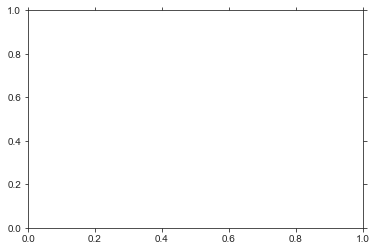

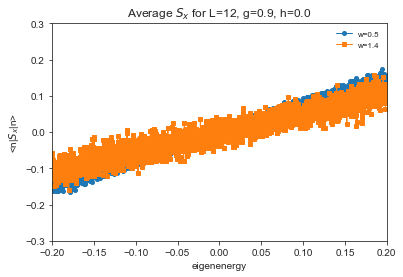

In [7]:
def plot_av_Sx(L,g,h,w, directory):
    try:
        plt.clf()
        plt.cla()
        folder = directory + '/av_Sx/'
        if not os.path.isdir(folder):
            os.mkdir(folder)
    except OSError:
        print("Creation of the directory %s failed" % (folder))
    else:
        sns.set_style("ticks")
        fig, ax = plt.subplots()
        legend = []
        title = "Average $S_x$ for L=" + str(L) + ", g=" + str(g) + ", h=" +str(h) 
        savefile = "avSx_L=" + str(L) + ",g=" + str(g) + ",h=" +str(h) + ",w="
        for filename in os.listdir(folder):
            if (filename[0:3] == "Sx_" and (filename[-4:] == '.txt' or filename[-4:] == '.dat')):
                splitter = filename[3:-4].split(',')
                # L, g, h, w
                splitter = [float(a.split('=')[-1]) for a in splitter]
                if (L == splitter[0] and g == splitter[1] and h == splitter[2] and splitter[3] in w):
                    #print(splitter)
                    legend.append("w=" + str(splitter[3]))
                    savefile = savefile + str(splitter[3])+","
                    tmp = pd.read_csv(folder + filename, sep = "\t\t",index_col=0, names = ['E','Sx'])
                    #print(tmp)
                    # PLOT 
                    tmp.plot(ax = ax
                            , linewidth=1
                            , marker=next(markers)
                            , markersize=4)
                    
        ax.set(title = title
            , xlabel = "eigenenergy"
            , ylabel = "<n|$S_x$|n>")
        ax.legend(legend
              , frameon=False
              , loc='best'
              , fontsize=8)
        ax.set_xlim([-0.2,0.2])
        ax.set_ylim([-0.3,0.3])
        plt.savefig(folder + savefile[:-1] + ".png")
        plt.show()

                    
plot_av_Sx(12,0.90,0.0,[0.00,0.50,1.40],"../results/disorder/")    

[12.0, 0.9, 0.0]


<ipython-input-9-2f188b0074b9>:22: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tmp = pd.read_csv(folder + filename, sep = "\t\t", names = ['w','bucket','r'])


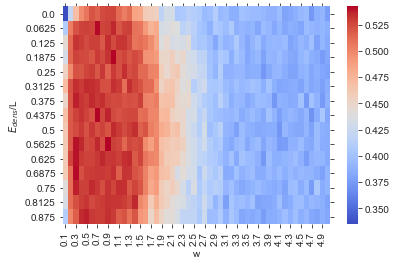

In [9]:
def plot_r_phase(L,g,h, directory):
    try:
        plt.clf()
        plt.cla()
        folder = directory + '/r_phase/'
        if not os.path.isdir(folder):
            os.mkdir(folder)
    except OSError:
        print("Creation of the directory %s failed" % (folder))
    else:
        sns.set_style("ticks")
        #fig, ax = plt.subplots()
        title = "r participation for L=" + str(L) + ", g=" + str(g) + ", h=" +str(h) 
        savefile = "r_L=" + str(L) + ",g=" + str(g) + ",h=" +str(h)
        for filename in os.listdir(folder):
            if (filename.startswith("PhaseDiagram") and (filename[-4:] == '.txt' or filename[-4:] == '.dat')):
                splitter = filename[:-4].split('_')[-1].split(',')
                # L, g, h, w
                splitter = [float(a.split('=')[-1]) for a in splitter]
                if (L == splitter[0] and g == splitter[1] and h == splitter[2]):
                    print(splitter)
                    tmp = pd.read_csv(folder + filename, sep = "\t\t", names = ['w','bucket','r'])
                    tmp.dropna()
                    #print(tmp)
                    tmp = tmp[tmp['r'] != 0.0]

                    #print(tmp)
                    pivotted= tmp.pivot('bucket','w','r')
                    # PLOT 
                    r = np.array(tmp['r'])
                    
                    sns.heatmap(pivotted,cmap='coolwarm',vmin=np.min(r), vmax=np.max(r))
                    
    
    plt.ylabel("$E_{dens}$/L")
    plt.savefig(folder + savefile + ".png")
    plt.show()                


                    
plot_r_phase(12,0.9,0.0,"../results/disorder/") 